<a href="https://colab.research.google.com/github/acollin19/comp551/blob/adam/assignment2_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Process:

### Task 1: Data Processing  


1. IMDB Reviews
2. 20 news groups: a multi-class labelled textual dataset


### Task 2: Implement Logistic and Multiclass classifiers

1. Logistic Regression
2. Multiclass Regression
3. Comparisons using ROC curve


### Task 3: Running Experiments



1.    Most positive/negative Z-scores
2.   Implement:  
    * Binary classification on the IMDB Reviews

  *   Multi-class classification on the 20 news group dataset

3. Binary classification AUROC on IMDB data
  *   Logistic Regression 
  *   KNN

4. Multiclass classification accuracy

5. Compare Accuracy of Models (Plot)







In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Multiclass Regression and ROC curve comparisons
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk import word_tokenize, download
from nltk.corpus import stopwords


In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  47.2M      0  0:00:01  0:00:01 --:--:-- 47.2M


In [ ]:
# IMDB dataset preprocession
IMDB_X_train, IMDB_y_train= load_svmlight_file('aclImdb/train/labeledBow.feat')
IMDB_X_test, IMDB_y_test = load_svmlight_file('aclImdb/test/labeledBow.feat') 

# IMDB_y_train[IMDB_y_train < 5] = -1.0
# IMDB_y_train[IMDB_y_train >= 5] = 1.0

# vectors = load_svmlight_file('aclImdb/train/labeledBow.feat')

'''
# Needs cleaning 
- choose the top D ∈ [100, 1000] features by their absolute z-score  using simple regression
''' 
print(IMDB_X_train)

  (0, 0)	9.0
  (0, 1)	1.0
  (0, 2)	4.0
  (0, 3)	4.0
  (0, 4)	6.0
  (0, 5)	4.0
  (0, 6)	2.0
  (0, 7)	2.0
  (0, 8)	4.0
  (0, 10)	4.0
  (0, 12)	2.0
  (0, 26)	1.0
  (0, 27)	1.0
  (0, 28)	1.0
  (0, 29)	2.0
  (0, 32)	1.0
  (0, 41)	1.0
  (0, 45)	1.0
  (0, 47)	1.0
  (0, 50)	1.0
  (0, 54)	2.0
  (0, 57)	1.0
  (0, 59)	1.0
  (0, 63)	2.0
  (0, 64)	1.0
  :	:
  (24999, 420)	1.0
  (24999, 421)	1.0
  (24999, 426)	1.0
  (24999, 427)	1.0
  (24999, 583)	1.0
  (24999, 585)	1.0
  (24999, 642)	1.0
  (24999, 679)	2.0
  (24999, 680)	1.0
  (24999, 1065)	1.0
  (24999, 1093)	1.0
  (24999, 1224)	1.0
  (24999, 1407)	1.0
  (24999, 1773)	1.0
  (24999, 3947)	1.0
  (24999, 4292)	1.0
  (24999, 4569)	1.0
  (24999, 4949)	1.0
  (24999, 5072)	1.0
  (24999, 5792)	1.0
  (24999, 5947)	1.0
  (24999, 9702)	1.0
  (24999, 12190)	1.0
  (24999, 12803)	1.0
  (24999, 15612)	1.0


In [ ]:
# 1st element in tuple represents the file its in, 2nd element represents the index of word it represents in vocab, float represents frequency
# want to remove the words that appear in less than 1% of all documents # only appear in 250 documents
# want to remove the words that appear in more than 50% of all documents # appear in 12500 documents
import scipy.sparse as sp
sign = sum(IMDB_X_train.sign()) # 1 if the word appears in the text 0 if not
good = (sign < 12500) - (sign < 250)
indices = sp.find(good)

IMDB_X_train = IMDB_X_train[:,indices[1]]
IMDB_X_train.todense()
print(IMDB_X_train)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


  (0, 2)	1.0
  (0, 5)	1.0
  (0, 14)	1.0
  (0, 18)	1.0
  (0, 20)	1.0
  (0, 23)	1.0
  (0, 27)	2.0
  (0, 30)	1.0
  (0, 32)	1.0
  (0, 36)	2.0
  (0, 37)	1.0
  (0, 39)	1.0
  (0, 41)	2.0
  (0, 43)	1.0
  (0, 45)	1.0
  (0, 51)	1.0
  (0, 73)	1.0
  (0, 79)	1.0
  (0, 89)	1.0
  (0, 95)	1.0
  (0, 98)	1.0
  (0, 109)	1.0
  (0, 113)	1.0
  (0, 115)	1.0
  (0, 123)	1.0
  :	:
  (24999, 176)	1.0
  (24999, 178)	1.0
  (24999, 206)	1.0
  (24999, 228)	1.0
  (24999, 240)	1.0
  (24999, 272)	1.0
  (24999, 277)	1.0
  (24999, 285)	1.0
  (24999, 310)	1.0
  (24999, 317)	1.0
  (24999, 320)	1.0
  (24999, 364)	1.0
  (24999, 393)	1.0
  (24999, 394)	1.0
  (24999, 399)	1.0
  (24999, 400)	1.0
  (24999, 556)	1.0
  (24999, 558)	1.0
  (24999, 615)	1.0
  (24999, 652)	2.0
  (24999, 653)	1.0
  (24999, 1038)	1.0
  (24999, 1066)	1.0
  (24999, 1195)	1.0
  (24999, 1369)	1.0


## Z-Score Function

In [ ]:
from sklearn.utils.extmath import sparse
# Z - Score
def zscore(X,y):

  N = X.shape[0]
  std = (IMDB_y_train- y.mean()) / y.std()
  z = np. abs(sp.csr_matrix.dot (sp.csr_matrix.transpose(X), std))

  return z


df = pd.DataFrame(IMDB_X_train.toarray())
df.insert(loc=0, column="A", value=IMDB_y_train)
IMDB_X_train = sp.csr_matrix(df.values)
IMDB_X_train.todense()
IMDB_arr = IMDB_X_train.toarray()

zscores = zscore(IMDB_X_train,IMDB_y_train)

zindex = np.argsort(zscores)[::-1][:400]

# trim feature set
IMDB_X_train = IMDB_X_train[:,zindex]
IMDB_X_test = IMDB_X_test[:,zindex]

# trim word list
vocab = pd.read_csv('aclImdb/imdb.vocab', names=['Words'])

vocab = vocab['Words'].tolist()

vocab = [vocab[i] for i in zindex]

print(vocab)
print(zscores)
print(zscores.shape[0])#1746

['the', 'you', 'she', 'a', 'time', 'at', 'with', '!', 'in', 'was', 'interesting', 'for', 'one', 'its', 'and', 'as', "don't", 'that', 'but', 'this', 'even', 'really', 'how', 'great', 'what', 'these', 'made', 'from', 'who', 'film', 'seen', 'well', 'so', 'to', 'me', 'enjoy', 'we', 'lost', 'had', 'no', 'series', 'main', 'need', 'when', 'better', 'it', 'home', 'be', 'classic', 'about', 'read', 'big', 'human', 'man', 'sure', 'old', 'only', 'during', 'i', 'let', "doesn't", 'another', 'called', 'is', 'watch', 'life', 'long', 'or', 'story', 'he', 'think', 'any', 'pretty', 'over', "i've", 'into', 'their', 'friend', 'both', 'down', 'us', 'have', 'movies', 'recommend', 'some', 'up', 'sex', 'on', 'little', 'writer', 'his', 'absolutely', 'see', 'there', 'where', 'why', 'after', 'thought', 'totally', 'good', 'them', 'show', 'someone', 'fact', 'then', 'movie', 'making', 'like', 'not', 'budget', 'bit', 'days', 'could', 'part', 'other', 'makes', 'again', 'nice', 'our', 'looking', 'woman', 'king', 'micha

# Task 1 : Data processing



## Task 1.2 : IMDB

 - X contain features based on the words in the movie reviews
 - y contain labels for whether the review sentiment is positive 1 or negative -1

In [ ]:
# IMDB train df
 
# IMDB_X_train, IMDB_y_train = load_svmlight_file('aclImdb/train/labeledBow.feat')
# IMDB_X_test, IMDB_y_test = load_svmlight_file('aclImdb/test/labeledBow.feat') 

# IMDB_y_train[IMDB_y_train < 5] = -1.0
# IMDB_y_train[IMDB_y_train >= 5] = 1.0

# QUESTION TO ANSWER: Do they make sense for calling a movie good and bad, respectively?


## Task 1.2 : Twenty Train

Text preprocessing, tokenizing and filtering of stopwords are all included in the CountVectorizer function


In [ ]:
# Loading 20 news group dataset
categories=['rec.sport.hockey','sci.electronics','talk.politics.guns','sci.space']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, remove=(['headers', 'footers', 'quotes']), shuffle=True, random_state=42)

download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once

# Tokenize, remove stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    # Remove stopwords
    doc = [word for word in doc if word not in stop_words]
    # Restricts string to alphabetic characters only
    doc = [word for word in doc if word.isalpha()] 
    return doc

corpus = [' '.join(preprocess(text)) for text in twenty_train.data]

In [ ]:
# Turn the text content into feature vectors
count_vect = CountVectorizer() 
X_train_counts = count_vect.fit_transform(corpus) # builds a dict of features and transforms docs to feature vectors

# Occurences to frequences : TF_IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_train_all = X_train_tfidf.toarray()
X_train_all.shape

(2330, 23593)

In [ ]:
y_cat = twenty_train.target
# convert array of class indices to one-hot encoded array
y_train = np.zeros((y_cat.size, y_cat.max() + 1))
y_train[np.arange(y_cat.size), y_cat] = 1

y_train.shape

(2330, 4)

In [ ]:
# Test data

twenty_train_test = fetch_20newsgroups(subset='test', categories=categories, remove=(['headers', 'footers', 'quotes']), shuffle=True, random_state=42)

X_new_counts = count_vect.transform(twenty_train_test.data)
X_test_all = tfidf_transformer.transform(X_new_counts)
X_test_all.shape

(1550, 23593)

In [ ]:
y_cat = twenty_train_test.target
# convert array of class indices to one-hot encoded array
y_test = np.zeros((y_cat.size, y_cat.max() + 1))
y_test[np.arange(y_cat.size), y_cat] = 1
y_test.shape

(1550, 4)

In [ ]:
# Mutual information # Takes about 2min
from sklearn.metrics import mutual_info_score

y_train = y_train.astype(int)
X_counts = X_train_counts.toarray()

MI_score = np.zeros((X_counts.shape[1], y_train.shape[1]))

for i in range(X_train_all.shape[1]):
  for j in range(y_train.shape[1]):
    MI_score[i][j] = mutual_info_score(X_counts[:,i], y_train[:,j])

In [ ]:
best_class_indices = np.zeros(( y_train.shape[1], 100), dtype=int)
for i in range(y_train.shape[1]):
  best_class_indices[i] = np.argpartition(MI_score[:,i],-100)[-100:]

In [ ]:
best_indices = np.unique(best_class_indices.flatten())
len(best_indices)

329

In [ ]:
key_features = count_vect.get_feature_names_out()[best_indices]
print(key_features)

['action' 'activities' 'advance' 'aerospace' 'agents' 'allen' 'altitude'
 'amendment' 'ames' 'amp' 'amplifier' 'amps' 'analog' 'anyone' 'apollo'
 'armed' 'arms' 'assault' 'astronomy' 'atf' 'atmosphere' 'audio' 'ban'
 'batf' 'battery' 'bd' 'bear' 'beat' 'believe' 'billion' 'booster'
 'boston' 'bruins' 'budget' 'buffalo' 'bure' 'calgary' 'carry' 'case'
 'champs' 'chi' 'chicago' 'child' 'children' 'chip' 'chips' 'circuit'
 'circuits' 'citizens' 'civil' 'clinton' 'coach' 'comet' 'commercial'
 'compound' 'computer' 'concealed' 'connected' 'constitution' 'control'
 'cooling' 'cost' 'country' 'court' 'crime' 'crimes' 'criminal'
 'criminals' 'cup' 'current' 'data' 'davidians' 'death' 'deaths' 'defend'
 'defense' 'delta' 'det' 'detect' 'detector' 'detroit' 'developed'
 'development' 'device' 'devices' 'devils' 'digital' 'division' 'drug'
 'drugs' 'dryden' 'dynamics' 'earth' 'edmonton' 'electrical' 'electronics'
 'elements' 'engines' 'espn' 'evidence' 'evil' 'exploration' 'fans' 'fbi'
 'federal'

In [ ]:
X_train = X_train_all[:,best_indices]
X_train.shape

(2330, 329)

In [ ]:
X_test = X_test_all.toarray()[:,best_indices]
X_test.shape

(1550, 329)

# Task 2 : Implementing Classes

## Task 2.1 : Logistic Regression Class

In [ ]:
# Logistic function
z = np.linspace(-5,5,100)
logistic = lambda z: 1./ (1 + np.exp(-z))

# From class Logistic Regression collab
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh
    
    def evaluate(self, y, y_pred):
      accuracy = np.sum(np.argmax(y_pred,axis=0) == np.argmax(y,axis=0)) / y.shape[0]
      return accuracy

# LogisticRegression.gradient = gradient  

In [ ]:
# Applying Logistic Regression on the IMDB data

model = LogisticRegression(verbose=True, add_bias=False)
fit = model.fit(IMDB_X_train,IMDB_y_train).predict(IMDB_X_train)

#prediction threshold
y_train_pred = model.predict(new_IMDB_X_train)
y_test_pred = model.predict(new_IMDB_X_test)
print(y_train_pred)
print(y_test_pred)

#Accuracy
y_train_accuracy = model.evaluate(IMDB_y_train, y_train_pred)
y_test_accuracy = model.evaluate(IMDB_y_test, y_test_pred)
print(y_train_accuracy)
print(y_test_accuracy)

# plt.plot(X_train, y_train, '.', label='dataset')
# plt.plot(X_train, prediction, 'g', alpha=.5, label='predictions')
# plt.xlabel('x')
# plt.ylabel(r'$y$')
# plt.legend()
# # plt.show()
# plt.savefig('IMDB_prediction.png', bbox_inches="tight", dpi=300)

TypeError: ignored

In [ ]:
'''
Check Gradient using small perturbation, 
monitor the cross-entropy as a function of iteration, 
and report your finding on both datasets
'''
# Initialize the gradient method of the LogisticRegression class with gradient function
# LogisticRegression.gradient = gradient             

In [ ]:
# Extra - Applying KNN on IMDB
knn = KNeighborsClassifier()
knn.fit(IMDB_X_train[:,:89523], IMDB_y_train)

pred = knn.predict(IMDB_X_test)[0]

print("Test Prediction for 0 : ", pred)

Test Prediction for 0 :  4.0


## Task 2.2 : Multiclass Regression Class

In [ ]:
# From class Multiclass Regression collab
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                #print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            #else:
                #print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

    def evaluate(self, y, y_pred):
      return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) / y.shape[0]

## Task 2.3 : Loss per Iteration and Gradient Check

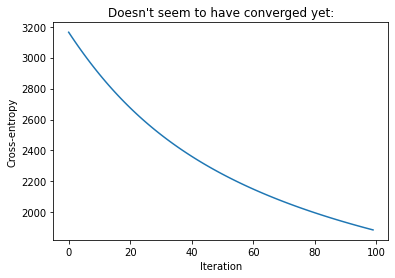

In [ ]:
# Multiclass for newsgroup
# No validation set

mlr = Multinomial_logistic(X_train.shape[1], y_train.shape[1])
losses, _ = mlr.fit(X_train, y_train)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Cross-entropy")
plt.title("Doesn't seem to have converged yet:")
plt.show()

In [ ]:
print("Gradient check: ", mlr.check_grad(X_train, y_train))

Gradient check:  3.631920307316512e-12


# Task 3 : Running Experiments

## Task 3.1 : Z-Scores
Report top 10 features with most positive/negative z-scores on the IMDB data using simple linear regression on the movie rating scores.

## Task 3.2.1: Binary Classification for IMDb

## Task 3.2.2 : Classification Accuracy for Multi-class Prediction

In [ ]:
print("Training accuracy: ", mlr.evaluate(mlr.predict(X_train), y_train))
print("Testing accuracy: ", mlr.evaluate(mlr.predict(X_test), y_test))

Training accuracy:  0.8163090128755365
Testing accuracy:  0.792258064516129


## Task 3.3 : AUROC of IMDb

In [ ]:
models = [KNeighborsClassifier(),
          DecisionTreeClassifier(),
          sk_LogisticRegression()]

perf = {}

# our implementation is slow you may try sklearn version
logitreg = LogisticRegression(max_iters=1e3)
fit = logitreg.fit(X_train, y_train)
y_test_prob = fit.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
auroc = roc_auc_score(y_test, y_test_prob)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit = model.fit(X_train, y_train)
    y_test_prob = fit.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auroc = roc_auc_score(y_test, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting Titanic survivor')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
# plt.show()
plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()

## Task 3.4 : KNN comparison for newsgroup

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("KNN training accuracy: ", knn.score(X_train, y_train))
print("KNN testing accuracy: ", knn.score(X_test, y_test))

KNN training accuracy:  0.7424892703862661
KNN testing accuracy:  0.6380645161290323


## Task 3.5 : Size comparison for news group

In [ ]:
train_accs = []
test_accs = []
knn_train_accs = []
knn_test_accs = []

sizes = [0.2, 0.4, 0.6, 0.8, 1]

for i in sizes:
  X_train_new = X_train[:int(i * X_train.shape[0])]
  y_train_new = y_train[:int(i * X_train.shape[0])]
  mlr = Multinomial_logistic(X_train_new.shape[1], y_train_new.shape[1])
  mlr.fit(X_train_new, y_train_new)
  train_accs.append(mlr.evaluate(mlr.predict(X_train_new), y_train_new))
  test_accs.append(mlr.evaluate(mlr.predict(X_test), y_test))

  knn = KNeighborsClassifier()
  knn.fit(X_train_new, y_train_new)
  knn_train_accs.append(knn.score(X_train_new, y_train_new))
  knn_test_accs.append(knn.score(X_test, y_test))

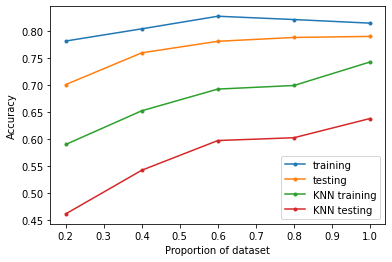

In [ ]:
plt.plot(sizes, train_accs, marker=".", label='training')
plt.plot(sizes, test_accs, marker=".", label='testing')
plt.plot(sizes, knn_train_accs, marker=".", label='KNN training')
plt.plot(sizes, knn_test_accs, marker=".", label='KNN testing')
plt.legend(loc='best')
plt.xlabel('Proportion of dataset')
plt.ylabel('Accuracy')
plt.show()

rec.sport.hockey key features: ['play' 'season' 'hockey' 'team' 'game']
sci.electronics key features: ['used' 'circuit' 'power' 'anyone' 'use']
sci.space key features: ['earth' 'nasa' 'moon' 'orbit' 'space']
talk.politics.guns key features: ['people' 'guns' 'fire' 'fbi' 'gun']


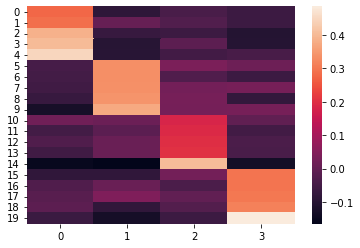

In [ ]:
from seaborn import heatmap

W_hat = mlr.W

best_indices = []
for i in range(4):
  best_indices.append(np.argsort(np.transpose(W_hat)[i])[-5:])

best_indices = np.array(best_indices).flatten()
W_hat_transformed = W_hat[best_indices]
W_hat_transformed = W_hat_transformed / W_hat_transformed.sum(axis=0)

print("rec.sport.hockey key features:", key_features[best_indices][:5])
print("sci.electronics key features:", key_features[best_indices][5:10])
print("sci.space key features:", key_features[best_indices][10:15])
print("talk.politics.guns key features:", key_features[best_indices][15:])

fig = heatmap(W_hat_transformed, cmap='rocket')

More experiments:

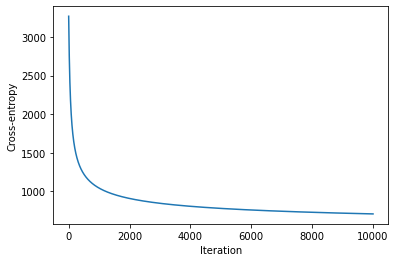

In [ ]:
# More iterations of multiclass

mlr = Multinomial_logistic(X_train.shape[1], y_train.shape[1])
losses, _ = mlr.fit(X_train, y_train, niter=10000)
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Cross-entropy")
plt.show()

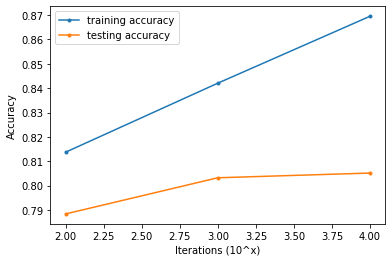

In [ ]:
# Accuracy by number of iterations

train_accs = []
test_accs = []

for i in [100, 1000, 10000]:
  mlr = Multinomial_logistic(X_train.shape[1], y_train.shape[1])
  losses, _ = mlr.fit(X_train, y_train, niter=i)
  train_accs.append(mlr.evaluate(mlr.predict(X_train), y_train))
  test_accs.append(mlr.evaluate(mlr.predict(X_test), y_test))

plt.plot(np.log10([100, 1000, 10000]), train_accs, marker='.', label='training accuracy')
plt.plot(np.log10([100, 1000, 10000]), test_accs, marker='.', label='testing accuracy')
plt.xlabel('Iterations (10^x)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

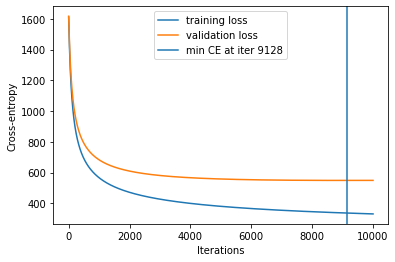

In [ ]:
# Validation loss: Find optimal number of iterations
from sklearn.model_selection import train_test_split

mlr = Multinomial_logistic(X_train.shape[1], y_train.shape[1])
X_train_new, X_valid, y_train_new, y_valid = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
train_loss, valid_loss = mlr.fit(X_train_new, y_train_new, X_valid, y_valid, niter=10000)
best_niter = valid_loss.argmin()

plt.plot(train_loss, label="training loss")
plt.plot(valid_loss, label="validation loss")
plt.axvline(x=best_niter, label=f"min CE at iter {best_niter}")
plt.xlabel("Iterations")
plt.ylabel("Cross-entropy")
plt.legend(loc='best')
plt.show()

In [ ]:
# Retraining using best_niter
mlr = Multinomial_logistic(X_train.shape[1], y_train.shape[1])
_, _ = mlr.fit(X_train_new, y_train_new, niter=best_niter)

print("Training accuracy: ", mlr.evaluate(mlr.predict(X_train_new), y_train_new))
print("Validation accuracy: ", mlr.evaluate(mlr.predict(X_valid), y_valid))
print("Testing accuracy: ", mlr.evaluate(mlr.predict(X_test), y_test))

Training accuracy:  0.8806866952789699
Validation accuracy:  0.7965665236051502
Testing accuracy:  0.792258064516129
